## Aim of the Project

The primary aim of this project is to develop, evaluate, and validate a robust volatility‐forecasting framework for an equally‐weighted multi‐asset portfolio. Specifically, we will:

1. **Fit and compare GARCH‐family models** (including GARCH(1,1), GARCH(2,1), GARCH(1,2), and EGARCH(1,1)) using in‐sample returns, in order to identify the most parsimonious specification that effectively captures volatility clustering and any leverage effects.

2. **Generate one‐day ahead volatility forecasts** from the chosen model(s) and translate these into 99.9% Value‐at‐Risk (VaR) estimates under a Gaussian innovation assumption.

3. **Backtest the VaR forecasts** over an out‐of‐sample period by:
   - Calculating realized portfolio log‐returns and comparing them to the predicted VaR bounds,
   - Applying Kupiec’s Proportion‐of‐Failures (POF) and Christoffersen’s Independence and Conditional Coverage tests to evaluate whether the observed exception frequency and timing match the nominal 1% target.


Through this workflow, we aim to identify a volatility‐risk model that reliably forecasts daily risk limits and passes both coverage and independence backtests—thereby delivering good model for real‐world risk management and regulatory compliance.  

### Setup and Libraries

In [1]:
import warnings; warnings.simplefilter('ignore')
from statsmodels.graphics.tsaplots import plot_acf
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as stats
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 5)

### Data Import

In [2]:
df_raw = pd.read_csv('data.csv', index_col=0, parse_dates=True)
df_raw.index = df_raw.index.date

### Defining the In-Sample and Out-of-Sample Split

We define a cutoff date of **May 1, 2024** to separate the in-sample period (used for model estimation) from the out-of-sample period (used for forecasting and evaluation).


In [3]:
cutoff = dt.date(2024, 5, 1)

In [4]:
df_insample = df_raw[df_raw.index < cutoff]

# Exploratory Data Analysis 

### Cumulative Returns of Portfolio Components

The plot below shows the **cumulative returns** of each asset in the portfolio over the in-sample period. Each time series is normalized to 1 at the starting date, allowing for a direct comparison of relative performance across assets.

This visualization helps identify which instruments grew the most (or declined) during the period and provides insight into potential diversification benefits.


<Axes: title={'center': 'Cumulative Returns'}>

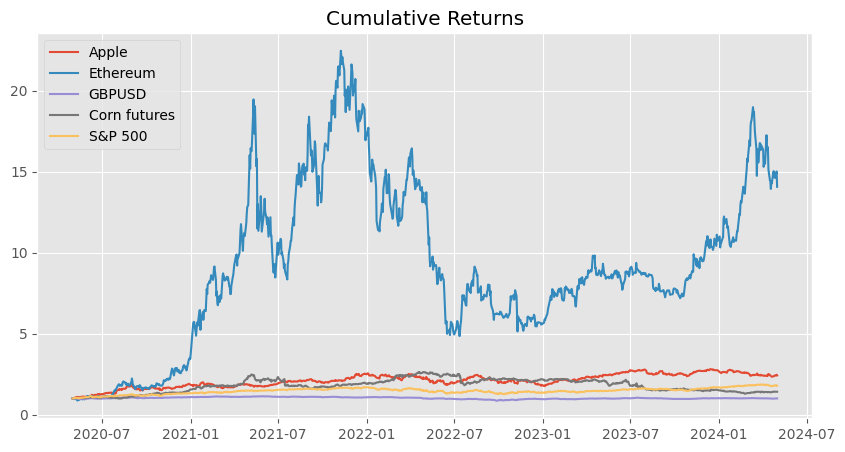

In [5]:
(df_insample / df_insample.iloc[0,:]).plot(title='Cumulative Returns', figsize=(10, 5), grid=True)

### Log Returns of Portfolio Components (In-Sample)

We compute the **daily logarithmic returns** for each asset in the portfolio during the in-sample period. This is done using the following formula:

$$
r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$

where:
- \( r_t \) is the log return at time \( t \),
- \( P_t \) is the price at time \( t \),
- \( P_{t-1} \) is the price at the previous time step.

Any resulting missing values (typically from the first row due to shifting) are dropped to ensure clean data for further analysis.


In [6]:
df_log_returns = np.log(df_insample / df_insample.shift(1))
df_log_returns = df_log_returns.dropna()

### Time Series of Log Returns for Individual Assets

The following subplots show the daily **log returns** of each asset in the portfolio during the in-sample period. 

Visual inspection of these time series allows us to:
- identify periods of increased or decreased volatility,
- observe potential **volatility clustering** (i.e., periods of high variability followed by more high variability),
- detect any visible anomalies or structural breaks in the return behavior.


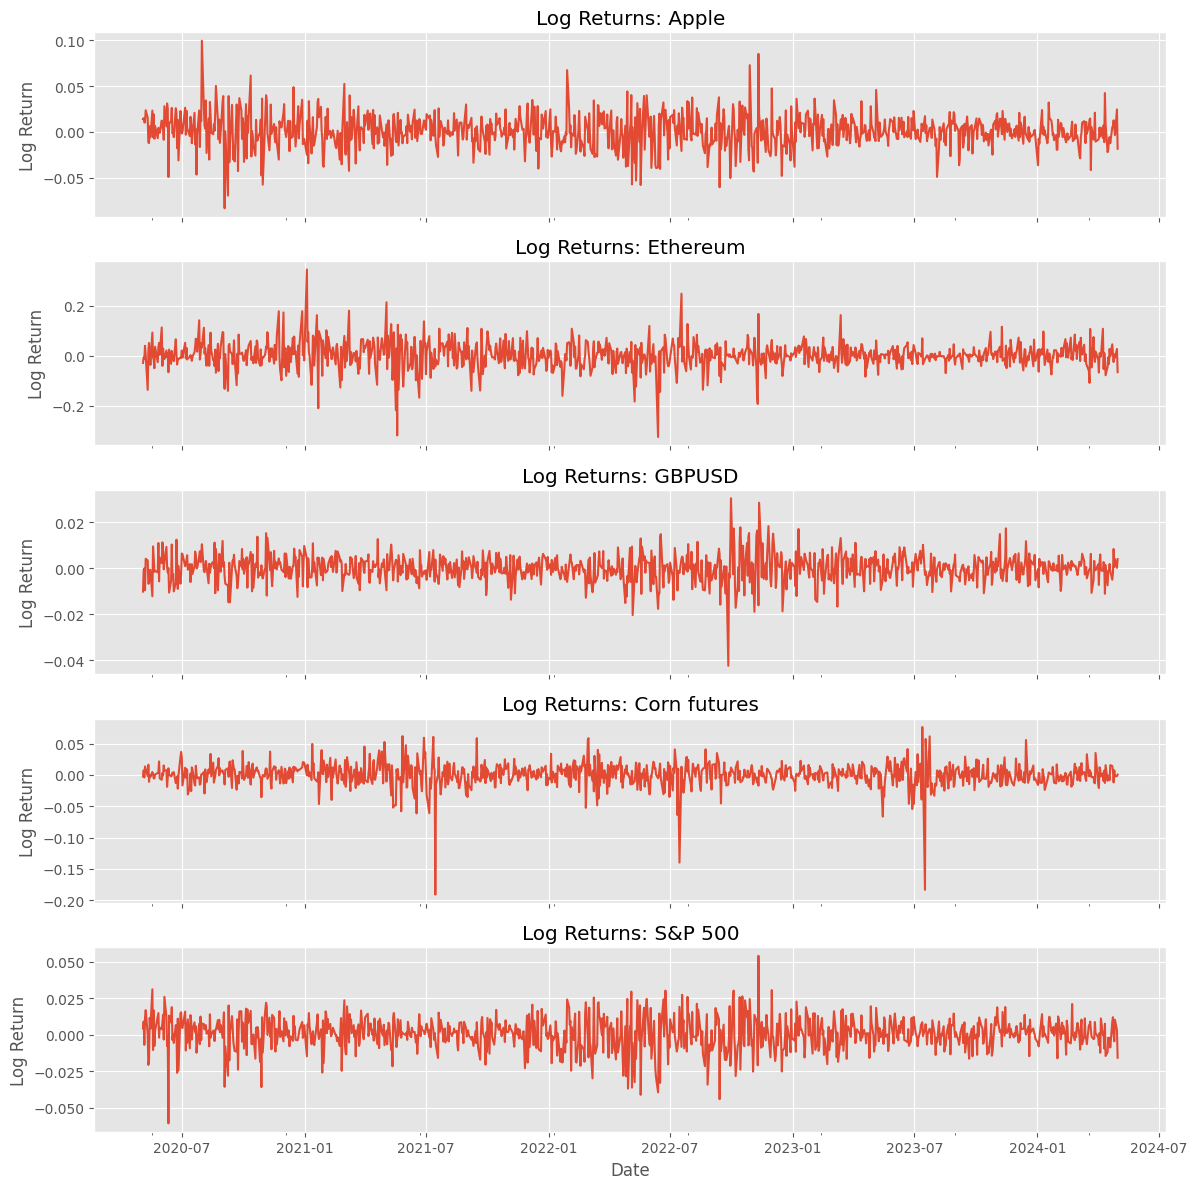

In [7]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 12), sharex=True)

for i, asset in enumerate(df_log_returns.columns):
    ax = axes[i]
    df_log_returns[asset].plot(ax=ax)
    ax.set_title(f"Log Returns: {asset}")
    ax.set_ylabel("Log Return")
    ax.grid(True)
axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()

### Volatility Comparison Across Assets

The bar chart below presents the **standard deviation** of log returns (expressed in %) for each asset in the portfolio during the in-sample period.

This metric serves as a proxy for each asset's historical volatility. Assets with higher standard deviation exhibit more return variability, which typically corresponds to higher risk. This visualization provides a clear comparison of relative volatility across the portfolio components.


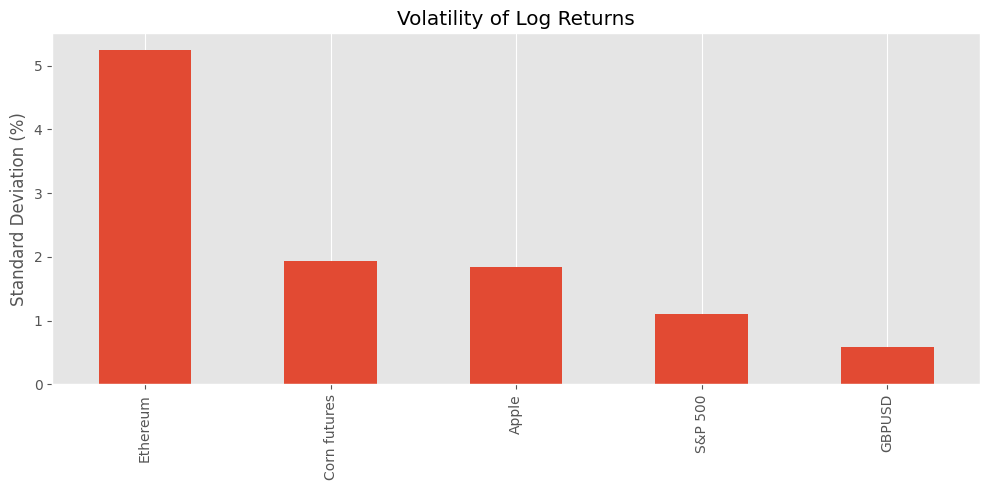

In [8]:
volatility = df_log_returns.std() * 100
volatility.sort_values(ascending=False).plot(kind='bar', figsize=(10, 5), 
                                             title='Volatility of Log Returns')
plt.ylabel("Standard Deviation (%)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Construction of Equally Weighted Portfolio and Log Returns

An **equally weighted portfolio** is constructed by allocating 20% of the initial investment to each of the five assets.

Steps:
- The initial portfolio value is set to 1.
- The number of shares for each asset is determined based on initial prices and equal weights.
- The portfolio value over time is calculated as the dot product of asset prices and the number of shares held.
- Finally, **portfolio log returns** are computed using the same lo


In [9]:
initial_value = 1
w = np.repeat(0.2, df_insample.shape[1])
allocation = initial_value * w
shares = allocation / df_insample.iloc[0]
portfolio = df_insample.dot(shares)

portfolio_insample = np.log(portfolio / portfolio.shift(1)).dropna()

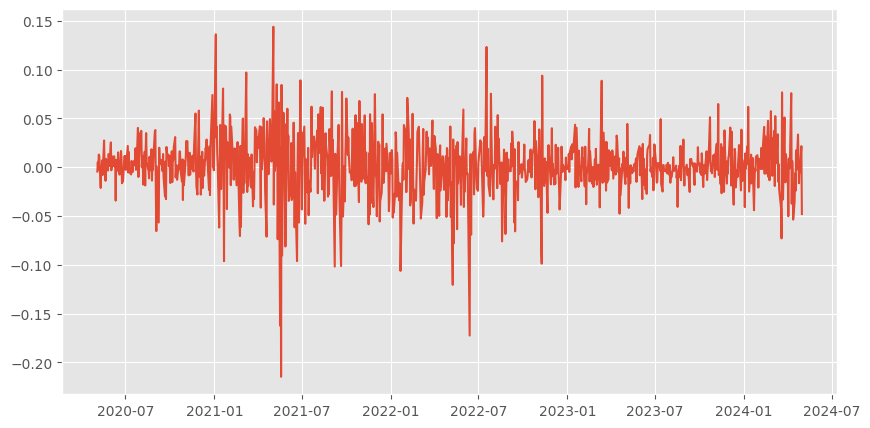

In [10]:
plt.plot(portfolio_insample)

### Distribution of Portfolio Log Returns and Kurtosis

The histogram below shows the distribution of the portfolio’s daily log returns, along with a **Kernel Density Estimate (KDE)** to provide a smooth approximation of the underlying probability density.

This allows us to assess the shape of the return distribution, particularly:
- its symmetry,
- presence of fat tails,
- deviation from normality.

To quantify this, we compute the **sample excess kurtosis** using Fisher’s definition. A positive excess kurtosis indicates **leptokurtosis** , a distribution with heavier tails and a sharper peak than the normal distribution.


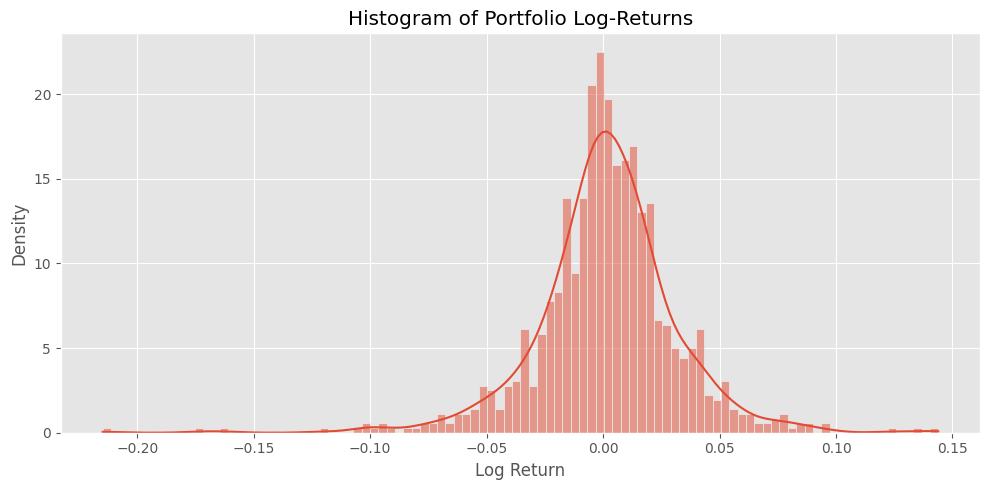

Sample excess kurtosis: 5.82


In [11]:
sns.histplot(portfolio_insample, bins=100, kde=True, stat='density')
plt.title('Histogram of Portfolio Log-Returns')
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()

kurt = stats.kurtosis(portfolio_insample, fisher=True)
print(f"Sample excess kurtosis: {kurt:.2f}")

### Autocorrelation of Squared Portfolio Returns

To detect the presence of **ARCH effects** and **volatility clustering**, we analyze the **autocorrelation of squared portfolio log returns**.

The first plot shows the raw ACF of squared returns. The second plot applies a scaled y-axis for better visibility of lower lags. Significant autocorrelations in squared returns indicate that large fluctuations tend to be followed by large fluctuations — a key feature of financial time series that motivates the use of GARCH-type models.


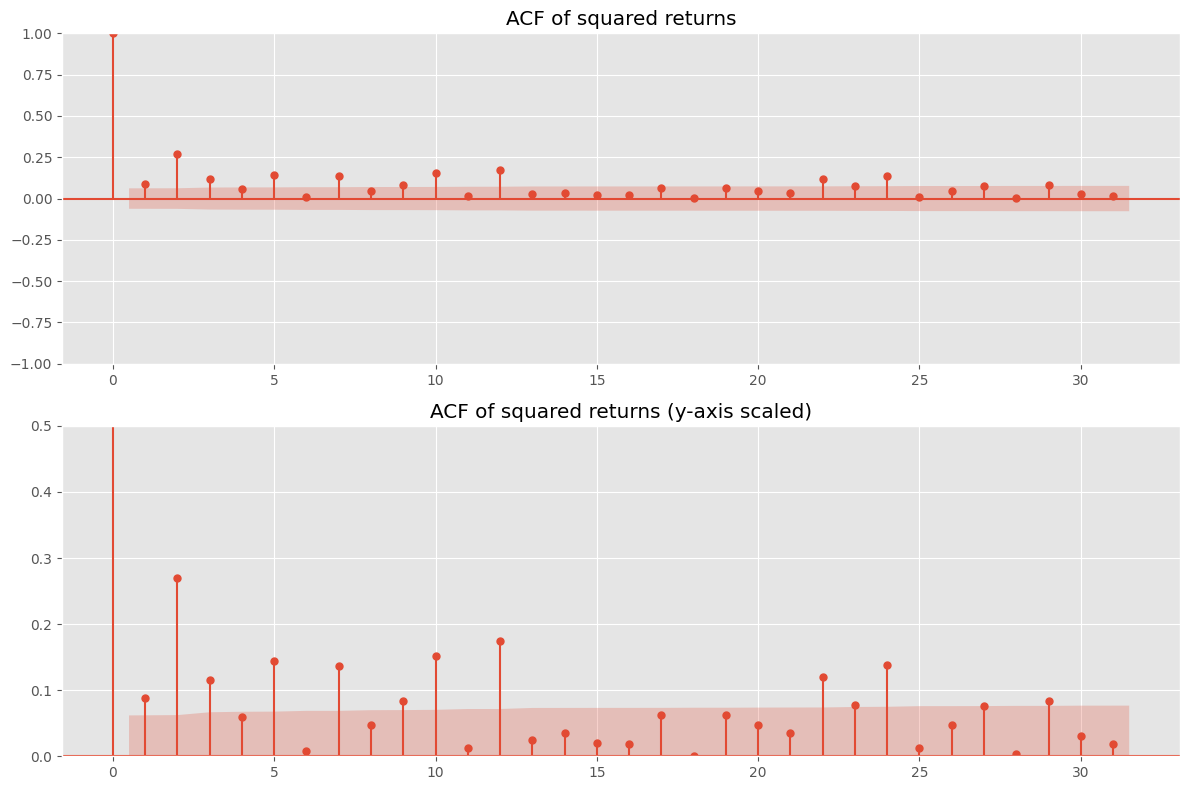

In [12]:
squared_returns_for_acf = (portfolio_insample ** 2).dropna()

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(squared_returns_for_acf, ax=axes[0], title="ACF of squared returns",)
plot_acf(squared_returns_for_acf, ax=axes[1], title="ACF of squared returns (y-axis scaled)", )
axes[1].set_ylim([0, 0.5])

plt.tight_layout()
plt.show()

### Returns vs. Next‐Day Volatility - Leverage effect
To explore how today’s log‐return relates to tomorrow’s volatility, we compute a 21‐day rolling standard deviation of in‐sample returns and then plot today’s return against the next day’s volatility. In many financial time series, large (positive or negative) returns often precede higher volatility (volatility clustering and leverage effects).

In [178]:
rets = portfolio_insample.copy()

window = 21
vol = rets.rolling(window).std() * np.sqrt(window)

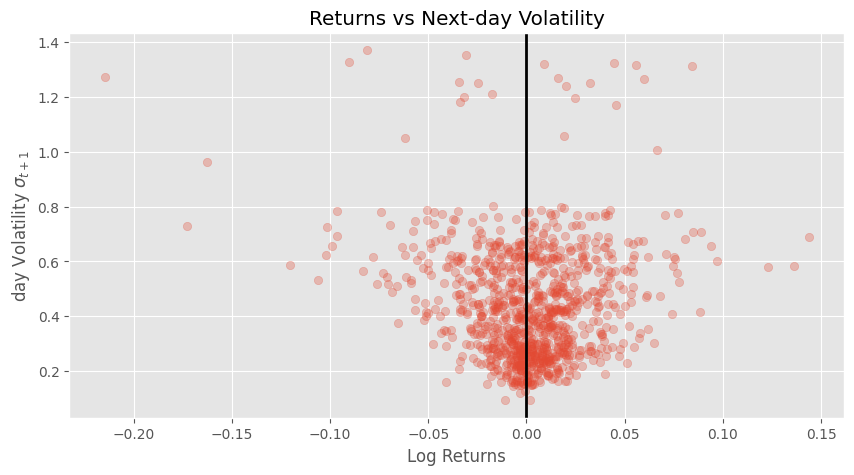

In [177]:
rets_lag = rets.iloc[:-1]
vol_next = vol.iloc[1:]

plt.scatter(rets_lag, vol_next, alpha=0.3)
plt.xlabel('Log Returns')
plt.ylabel(f'day Volatility $σ_{{t+1}}$')
plt.title('Returns vs Next-day Volatility')
plt.axvline(0, color='k', lw=2)
plt.show()


### Rolling Correlation Between Returns and Volatility
Below we compute and plot the 252-day (about one trading year) rolling correlation between daily log-returns and the corresponding 21-day rolling volatility. A persistent negative correlation often reflects the leverage effect (i.e. negative returns tend to be followed by higher volatility), while occasional positive patches can hint at volatility feedback or regime shifts.

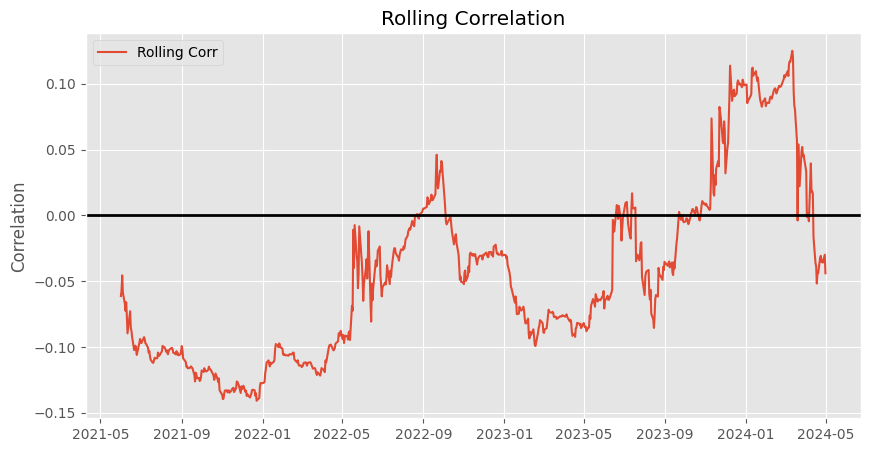

In [15]:
corr_window = 252
rolling_corr = rets.rolling(corr_window).corr(vol)

plt.plot(rolling_corr.index, rolling_corr, label=f'Rolling Corr')
plt.axhline(0, color='k', lw=2)
plt.title(f'Rolling Correlation')
plt.ylabel('Correlation')
plt.legend()
plt.show()

### Rolling MAD vs. Rolling Standard Deviation
To compare a robust dispersion measure (mean absolute deviation, MAD) to the usual standard deviation, we compute 21‐day rolling MAD and 21‐day rolling standard deviation, each annualized by multiplying by 252. Plotting them together helps highlight periods when the sample distribution deviates from Gaussian‐like behavior (since MAD is less sensitive to outliers than standard deviation as it is in norm 1 and generally more robust).

MAD vs STD also helps to idetify how "kurtotic" time series is.

In [16]:
def mad_calc(ts, rolling_window):
    rolling_mean = ts.rolling(rolling_window).mean()
    absolute_deviations = (ts - rolling_mean).abs()
    mads = absolute_deviations.rolling(rolling_window).mean()    
    return mads * np.sqrt(252)

def standard_dev_rolling(ts, rolling_window):
    ts = ts.copy()
    trading_periods = 252/rolling_window
    roll_std = ts.rolling(rolling_window).std()

    return roll_std * np.sqrt(252)

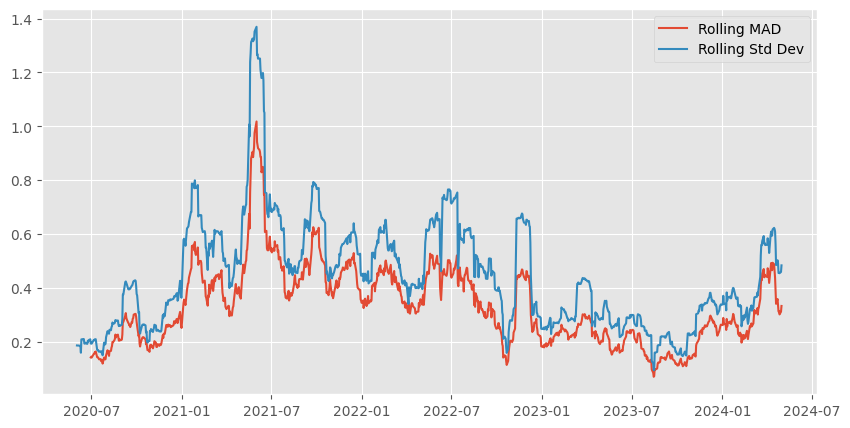

In [17]:
rolling_std = standard_dev_rolling(rets, 21)
rolling_MAD = mad_calc(rets, 21)
rolling_MAD.plot(label='Rolling MAD')
rolling_std.plot(label='Rolling Std Dev')
plt.legend()

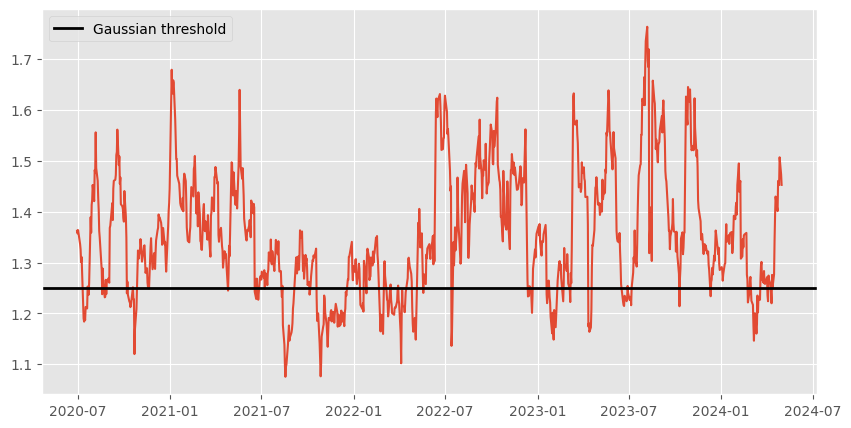

In [18]:
(rolling_std/rolling_MAD).plot()
plt.axhline(1.25, color='k', lw=2, label = "Gaussian threshold")
plt.legend()

### MS-Plot for Tail-Behavior Diagnostics

The **MS-plot** (Maximum-to-Sum plot) is a simple tool to explore the tail behavior of a univariate series ${X_t}$. For each power $p$, we compute:

1. $y_n = |X_n|^p$.  
2. The partial sums $S_n = \sum_{i=1}^n y_i$.  
3. The running maximum $M_n = \max_{1 \le i \le n} y_i$.  
4. The ratio  
   $$
     R_n^{(p)} = \frac{M_n}{S_n}.
   $$

Under a light-tailed (e.g., sub-exponential or Gaussian) regime, $R_n^{(p)}$ tends to zero as $n \to \infty$, because no single observation dominates the total sum. However, if the series is heavy-tailed—especially if $\mathbb{E}[|X|^p] = \infty$ for a given $p$—then $R_n^{(p)}$ will not converge to zero. By plotting $R_n^{(p)}$ over $n$ for several choices of $p$, we can visually check which moments may be infinite (i.e., detect power-law behavior).

Below is a function `MSplot` that, given a 1D array or `Series` `data` and a maximum power $p$, produces a $2\times2$ grid of plots. Each panel shows the curve of 
$$
  R_n^{(p)} = \frac{\max_{1\le i \le n} |X_i|^p}{\sum_{i=1}^n |X_i|^p},
$$
for $p = 1, 2, 3, 4$. The horizontal axis is the sample index $n$, and the vertical axis is $R_n^{(p)}$. If $R_

In [21]:
def MSplot(data, p=4, save_path=None):
    plt.figure(figsize=(10,8))
    plt.subplots_adjust(hspace=0.4)
    x = np.abs(data)
    fig, axes = plt.subplots(2, 2, figsize=(10,8))
    for i in range(1, p+1):
        y = np.power(x, i)
        S = np.cumsum(y)
        M = np.maximum.accumulate(y)
        R = M / S
        ax = axes[(i-1)//2, (i-1)%2]
        ax.plot(np.arange(1, len(x)+1), R)
        ax.set_xlabel('n')
        ax.set_ylabel('Rn')
        ax.set_title(f'MSplot for p={i}')
    
    plt.tight_layout()
    plt.show()

<Figure size 1000x800 with 0 Axes>

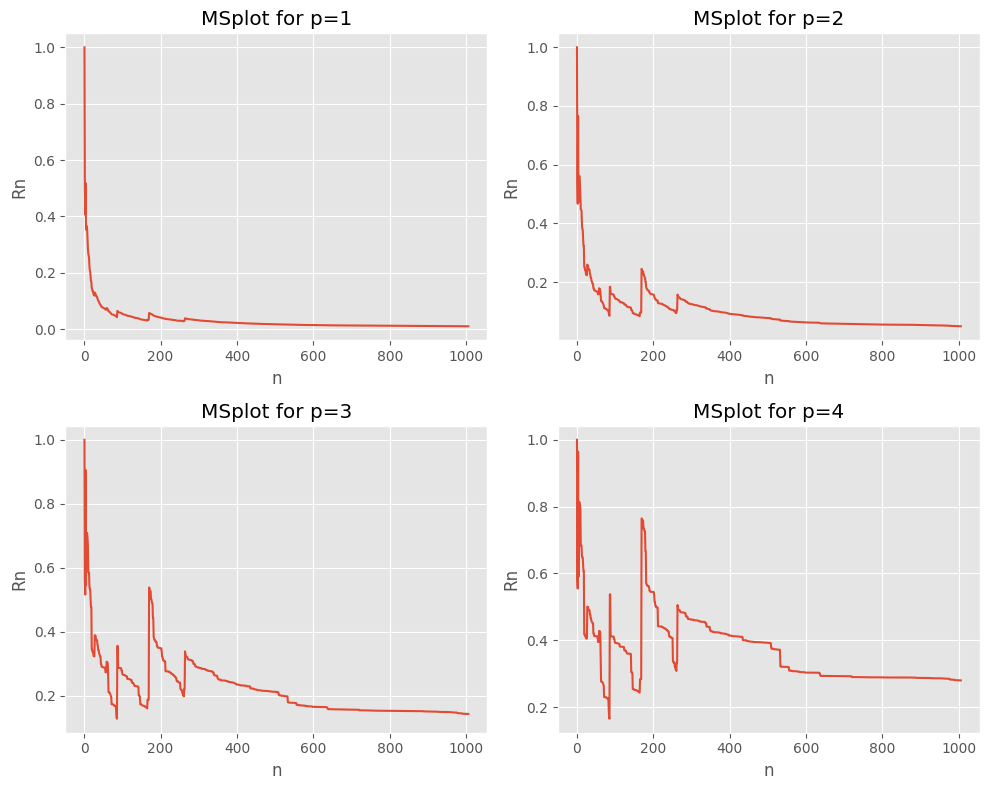

In [22]:
MSplot(portfolio_insample)

### QQ Plot Against an Exponential Distribution

Below, we construct two QQ plots that compare the empirical distribution of **positive** returns (and, separately, the absolute values of **negative** returns) against a fitted exponential law.  This can help assess whether the upper‐tail (for gains) or the lower‐tail (for losses) of our return series resembles an exponential distribution.

---

#### 1. Rationale

- **Exponential Distribution**  
  The exponential distribution with rate (or “intensity”) parameter $\lambda$ has density
  $$
    f(x) = \lambda\,e^{-\lambda x}, 
    \quad x \ge 0,
  $$
  and mean $1/\lambda$.  It is often used to model “time between events” or to approximate light‐tailed behavior beyond a threshold.  

- **Tail‐Separate QQ Plots**  
  By splitting the return series $r_t$ into:
  1. $\{\,r_t > 0\}$ (positive returns, modeling the right tail), and  
  2. $\{|r_t| : r_t < 0\}$ (absolute negative returns, modeling the left tail),  
  we can fit an exponential law separately to each side and visually check for exponentiality.  If the QQ plot points lie close to the $45^\circ$ diagonal line, then the chosen exponential model is plausible for that tail.


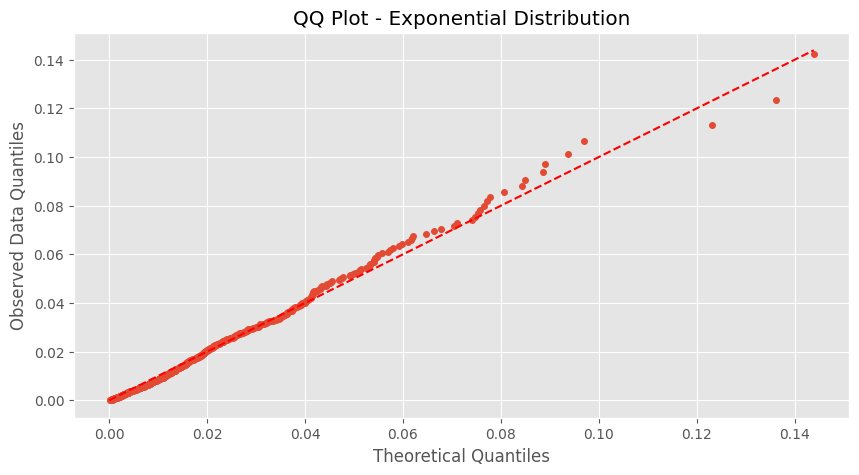

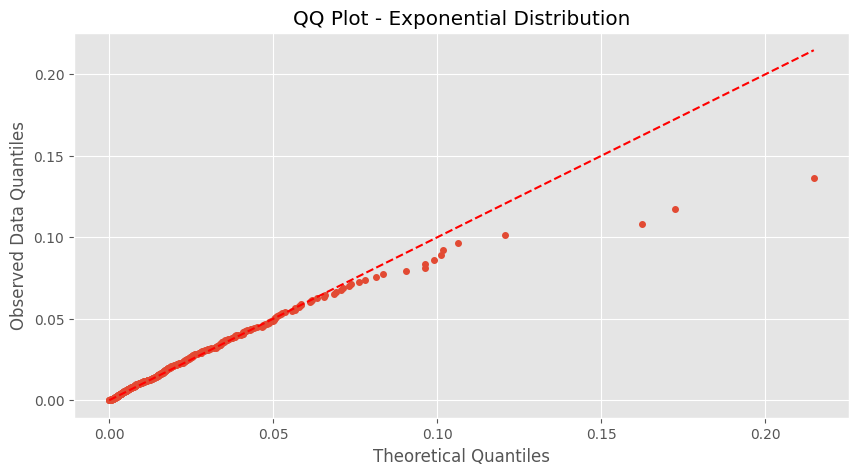

In [23]:
from scipy.stats import expon, probplot

def qqplot(data, save_path=None):
    data = np.sort(data.astype(float))
    intensity = 1 / np.mean(data)

    theoretical_quantiles = expon.ppf(np.linspace(0.01, 0.99, 100), scale=1 / intensity)

    ordered_data_quantiles, theoretical_quantiles = probplot(data, dist=expon(scale=1 / intensity), fit=False)
    plt.plot(theoretical_quantiles, ordered_data_quantiles, 'o', markersize=4)

    max_value = max(np.max(theoretical_quantiles), np.max(ordered_data_quantiles))
    min_value = min(np.min(theoretical_quantiles), np.min(ordered_data_quantiles))
    plt.plot([min_value, max_value], [min_value, max_value], 'r--', label='Diagonal')

    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Observed Data Quantiles')
    plt.title('QQ Plot - Exponential Distribution')
    plt.show()

qqplot(portfolio_insample[portfolio_insample>0])
qqplot(portfolio_insample[portfolio_insample<0].abs())

As you can see relying on sqaured variance (kurtosis) is not the best idea in general, but let's see

_____ 

# Models

# In-Sample

### In-Sample GARCH Model Selection

Below is the Python code used to fit a grid of GARCH $(p,q)$ models to the in-sample return series, compute diagnostic statistics (AIC, Ljung–Box tests, and ARCH‐LM test), and then summarize and select the best specifications. This entire block runs through all combinations of $p, q \in \{1,2,3\}$.


In [ ]:
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

In [31]:
specs = [(p,q) for p in range(1,4) for q in range(1,4)]
results = []

for p, q in specs:
    model = arch_model(portfolio_insample, mean='constant', vol='GARCH', p=p, q=q)
    res   = model.fit(disp='off')
    
    std_resid = res.std_resid.dropna()
    
    lb_resid    = acorr_ljungbox(std_resid, lags=[10], return_df=True)['lb_pvalue'].iloc[0]
    lb_resid2   = acorr_ljungbox(std_resid**2, lags=[10], return_df=True)['lb_pvalue'].iloc[0]
    
    arch_lm     = het_arch(std_resid, nlags=10)[1]
    
    results.append({
        'p': p, 'q': q,
        'AIC': res.aic,
        'LB_resid_p': lb_resid,
        'LB_resid2_p': lb_resid2,
        'ARCH_LM_p': arch_lm
    })

df_results = pd.DataFrame(results).sort_values('AIC').reset_index(drop=True)
print(df_results)

   p  q          AIC  LB_resid_p  LB_resid2_p  ARCH_LM_p
0  1  1 -4387.461142    0.328931     0.292794   0.249432
1  1  2 -4385.461198    0.329002     0.293131   0.249791
2  3  2 -4384.635775    0.321127     0.384767   0.357743
3  3  1 -4384.052685    0.339338     0.355960   0.316273
4  2  2 -4383.504980    0.325982     0.308882   0.271649
5  2  3 -4382.682010    0.289865     0.204952   0.167868
6  2  1 -4381.607275    0.367808     0.433552   0.418508
7  1  3 -4375.156700    0.291001     0.061584   0.055534
8  3  3 -4374.172736    0.300105     0.120549   0.097431


In [32]:
best_specs = df_results[
    (df_results[['LB_resid_p','LB_resid2_p','ARCH_LM_p']] > 0.05).all(axis=1)
].head(2)

print("Selected specs:\n", best_specs[['p','q','AIC']])

Selected specs:
    p  q          AIC
0  1  1 -4387.461142
1  1  2 -4385.461198


In [35]:
best_specs

,p,q,AIC,LB_resid_p,LB_resid2_p,ARCH_LM_p
0,1,1,-4387.461142,0.328931,0.292794,0.249432
1,1,2,-4385.461198,0.329002,0.293131,0.249791


Among all candidate specifications, we ultimately select **GARCH(1,1)** as our primary in‐sample model because it strikes the best balance between parsimony and adequacy—the simplest model with no remaining autocorrelation or ARCH effects in the standardized residuals.  Although a slightly more complex specification might achieve a marginally lower AIC in‐sample, the incremental gain does not justify additional parameters.  

To account for potential asymmetry in the volatility response (i.e., leverage effects), we also include **EGARCH(1,1)** as a secondary model: it retains the same parsimony level (one ARCH term and one GARCH term) but allows negative shocks to have a different impact on future variance than positive shocks.  Together, these two specifications—GARCH(1,1) for its simplicity and EGARCH(1,1) for its asymmetric flexibility—provide a robust foundation for our out‐of‐sample forecasting and further risk‐management analyses.


### In‐Sample Model Diagnostics and Comparison

Below we fit four volatility models—GARCH(1,1), GARCH(2,1), GARCH(1,2), and EGARCH(1,1)—to our in‐sample return series. We then:

1. **Plot the conditional volatility** ($\sigma_t$) from each model on the same time axis,  
2. **Examine the ACF of standardized residuals** ($\hat{\varepsilon}_t / \hat{\sigma}_t$) for each model up to lag 20,  
3. **Examine the ACF of squared standardized residuals** ($(\hat{\varepsilon}_t / \hat{\sigma}_t)^2$) for each model up to lag 20,  
4. Draw a conclusion about which specification best balances fit and parsimony.

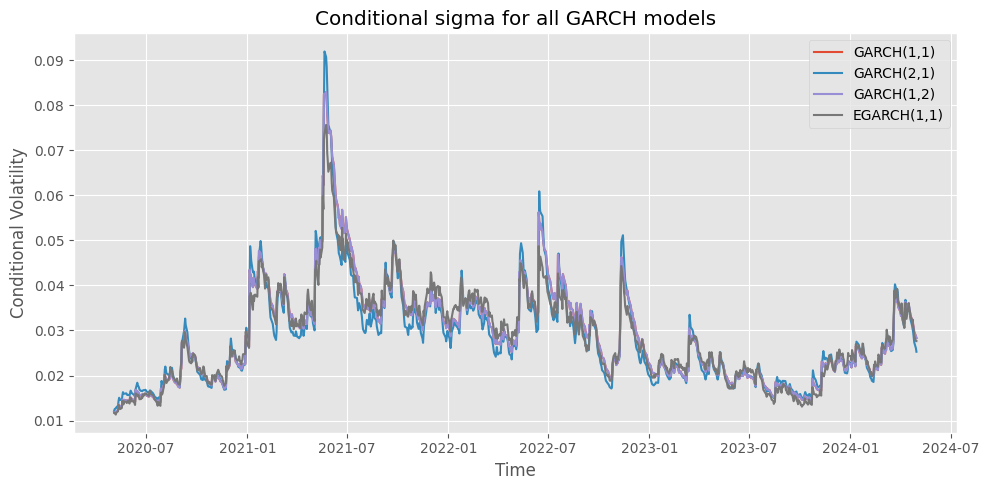

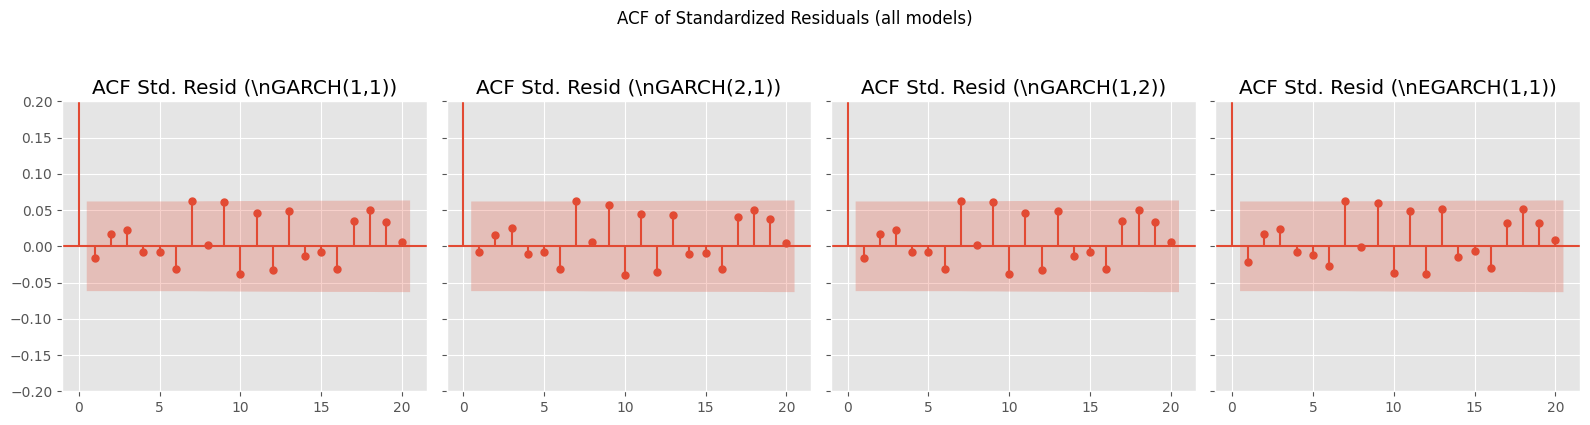

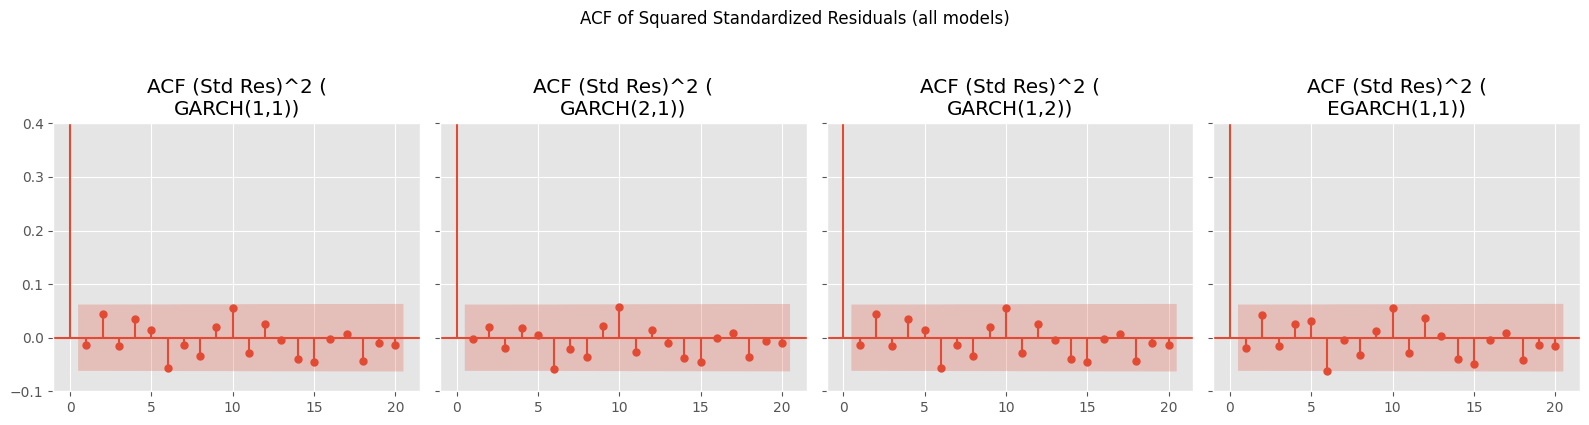

In [128]:
specs = [
    ("GARCH(1,1)",   "GARCH", 1, 1),
    ("GARCH(2,1)",   "GARCH", 2, 1),
    ("GARCH(1,2)",   "GARCH", 1, 2),
    ("EGARCH(1,1)", "EGARCH", 1, 1),
]

results = []

for label, vol_type, p, q in specs:
    res = arch_model(
        portfolio_insample,
        mean="constant",
        vol=vol_type,
        p=p,
        q=q
    ).fit(disp="off")
    results.append((label, res))

plt.figure(figsize=(10, 5))
for label, res in results:
    plt.plot(
        res.conditional_volatility,
        label=label
    )

plt.title("Conditional sigma for all GARCH models")
plt.xlabel("Time")
plt.ylabel("Conditional Volatility")
plt.legend()
plt.tight_layout()
plt.show()


num_models = len(results)
fig, axes = plt.subplots(1, num_models, figsize=(4 * num_models, 4), sharey=True)

for idx, (label, res) in enumerate(results):
    plot_acf(
        res.std_resid.dropna(),
        lags=20,
        ax=axes[idx]
    )
    axes[idx].set_title(f"ACF Std. Resid (\\n{label})")
    axes[idx].set_ylim(-0.2, 0.2)

fig.suptitle("ACF of Standardized Residuals (all models)", y=1.05)
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, num_models, figsize=(4 * num_models, 4), sharey=True)
for idx, (label, res) in enumerate(results):
    plot_acf(
        res.std_resid.dropna() ** 2,
        lags=20,
        ax=axes[idx]
    )
    axes[idx].set_title(f"ACF (Std Res)^2 (\n{label})")
    axes[idx].set_ylim(-0.1, 0.4)

fig.suptitle("ACF of Squared Standardized Residuals (all models)", y=1.05)
plt.tight_layout()
plt.show()


- **Primary Model: GARCH(1,1)**  
  - Chosen for its minimal parameterization, excellent in‐sample diagnostics (no residual autocorrelation or ARCH), and virtually identical $\sigma_t$ trajectory to higher‐order variants.  

- **Secondary Model: EGARCH(1,1)**  
  - Matches GARCH(1,1)’s parsimony but adds the ability to model an asymmetric (leverage) effect. It will be used alongside GARCH(1,1) to check whether negative shocks have a different impact on future volatility.

These two specifications—GARCH(1,1) for simplicity and EGARCH(1,1) for asymmetry—provide a robust foundation for all subsequent out‐of‐sample forecasting, risk‐management, and backtesting exercises.  


In [179]:
lb_std_dict = {}
lb_sq_dict  = {}

for label, res in results:
    std_resid = res.std_resid.dropna()
    std_resid_sq = std_resid ** 2
    
    lb_std = acorr_ljungbox(std_resid, lags=[10, 20], return_df=True).round(3)
    lb_sq  = acorr_ljungbox(std_resid_sq, lags=[10, 20], return_df=True).round(3)
    
    lb_std = lb_std.rename(
        columns={
            "lb_stat": f"{label} Q-stat",
            "lb_pvalue": f"{label} p-value"
        }
    )
    lb_sq = lb_sq.rename(
        columns={
            "lb_stat": f"{label} Q-stat",
            "lb_pvalue": f"{label} p-value"
        }
    )
    
    lb_std_dict[label] = lb_std
    lb_sq_dict[label]  = lb_sq

lb_std_df = pd.concat(lb_std_dict.values(), axis=1)
lb_std_df.index.name = "Lag"
lb_sq_df  = pd.concat(lb_sq_dict.values(), axis=1)
lb_sq_df.index.name = "Lag"

print("\n== LB on Standardized Residuals ==")
print(lb_std_df)
print("\n== LB on Squared Standardized Residuals ==")
print(lb_sq_df)


== LB on Standardized Residuals ==
     GARCH(1,1) Q-stat  GARCH(1,1) p-value  GARCH(2,1) Q-stat  \
Lag                                                             
10              11.377               0.329             10.869   
20              23.322               0.273             23.100   

     GARCH(2,1) p-value  GARCH(1,2) Q-stat  GARCH(1,2) p-value  \
Lag                                                              
10                0.368             11.376               0.329   
20                0.284             23.321               0.273   

     EGARCH(1,1) Q-stat  EGARCH(1,1) p-value  
Lag                                           
10               11.359                0.330  
20               24.354                0.227  

== LB on Squared Standardized Residuals ==
     GARCH(1,1) Q-stat  GARCH(1,1) p-value  GARCH(2,1) Q-stat  \
Lag                                                             
10              11.885               0.293             10.079   
20         

In [180]:
for label, res in results:
    print(f"\n===== {label} Summary =====")
    print(res.summary())


===== GARCH(1,1) Summary =====
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2197.73
Distribution:                  Normal   AIC:                          -4387.46
Method:            Maximum Likelihood   BIC:                          -4367.81
                                        No. Observations:                 1005
Date:                Sat, May 31 2025   Df Residuals:                     1004
Time:                        19:55:36   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.7295e-03  7.3

Below we compare the empirical distribution of standardized residuals from each fitted model (GARCH(1,1), GARCH(2,1), GARCH(1,2), and EGARCH(1,1)) against a standard normal density.  Because a correctly‐specified GARCH‐family model should produce residuals that (approximately) follow a standard normal distribution, any systematic deviations—especially in the tails—highlight mismatches and suggest a non‐Gaussian error law may be more appropriate.


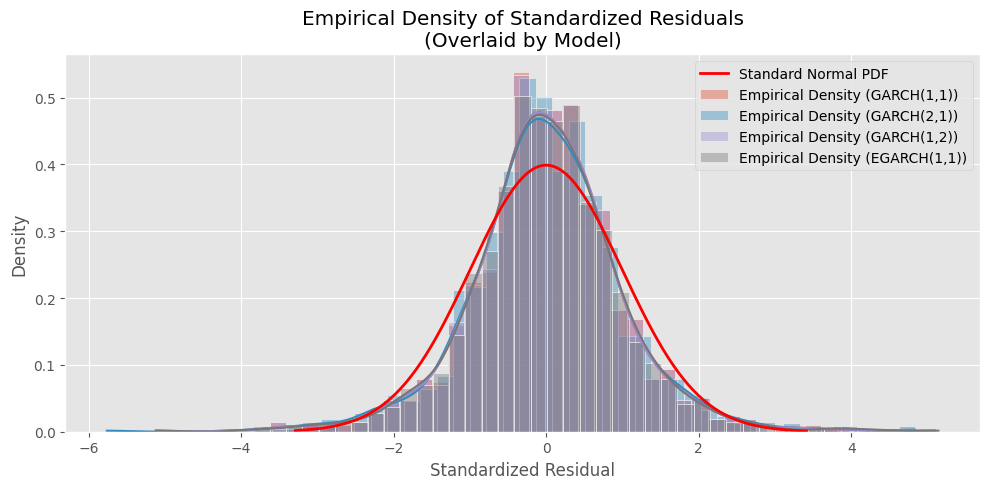

In [169]:
for label, res in results:
    std_resid = res.std_resid.dropna()
    sns.histplot(
        std_resid,
        kde=True,
        stat="density",
        label=f"Empirical Density ({label})",
        alpha=0.4,
    )

all_resid = np.concatenate([res.std_resid.dropna().values for _, res in results])
x_min, x_max = np.percentile(all_resid, [0.5, 99.5])
x_norm = np.linspace(x_min, x_max, 200)
plt.plot(
    x_norm,
    stats.norm.pdf(x_norm, loc=0, scale=1),
    label="Standard Normal PDF",
    color="red",
    linewidth=2
)

plt.title("Empirical Density of Standardized Residuals\n(Overlaid by Model)")
plt.xlabel("Standardized Residual")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

By adopting a fat‐tailed error distribution, we could reconcile the observed leptokurtosis in standardized residuals and improve the model’s accuracy for forecasting rare, high‐impact returns.  

### Q–Q Plot of Standardized Residuals (All Models)

Below is a Q–Q plot comparing the distribution of standardized residuals from each fitted model—GARCH(1,1), GARCH(2,1), GARCH(1,2), and EGARCH(1,1)—against the theoretical quantiles of a standard normal distribution.  A perfectly Gaussian set of residuals would lie exactly on the 45° reference line; systematic departures indicate non‐normality (e.g., heavy tails or skewness).


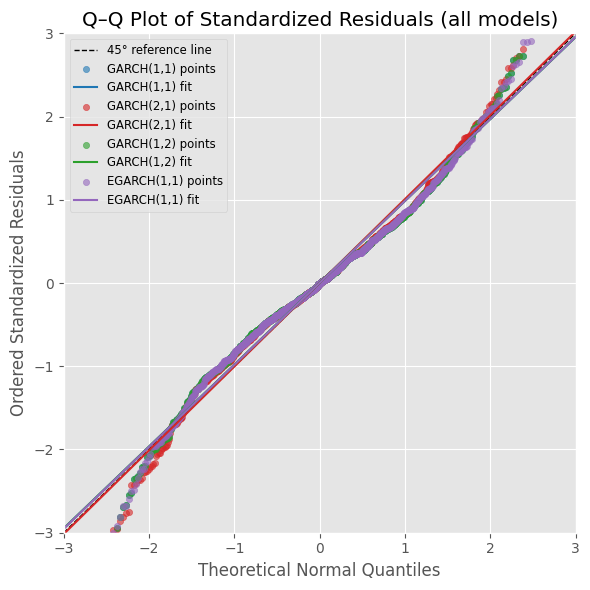

In [131]:
models = results.copy()
colors = ["tab:blue", "tab:red", "tab:green", "tab:purple"]

plt.figure(figsize=(6, 6))

lims = (-3, 3)
plt.plot(
    lims, lims,
    linestyle="--",
    color="k",
    linewidth=1,
    label="45° reference line"
)

for (label, res), color in zip(models, colors):
    std_resid = res.std_resid.dropna().values
    (osm, osr), (slope, intercept, r) = stats.probplot(std_resid, dist="norm", fit=True)

    plt.scatter(
        osm,
        osr,
        s=20,
        alpha=0.6,
        color=color,
        label=f"{label} points"
    )

    plt.plot(
        osm,
        slope * osm + intercept,
        color=color,
        linewidth=1.5,
        label=f"{label} fit"
    )

plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Theoretical Normal Quantiles")
plt.ylabel("Ordered Standardized Residuals")
plt.title("Q–Q Plot of Standardized Residuals (all models)")
plt.legend(loc="upper left", fontsize="small", ncol=1)
plt.tight_layout()
plt.show()


In [132]:
def compare_ICs_arch_models(model_results_dict):

    if not model_results_dict:
        print("No model results provided.")
        return pd.DataFrame()

    ic_data = []
    for name, res in model_results_dict.items():
        if hasattr(res, 'aic') and hasattr(res, 'bic'):
            ic_data.append({
                'Model': name,
                'AIC': res.aic,
                'BIC': res.bic,
                'LogLikelihood': res.loglikelihood,
                'Num Params': len(res.params)
            })
        else:
            print(f"Warning: Model {name} does not have standard IC attributes.")
            ic_data.append({
                'Model': name,
                'AIC': np.nan,
                'BIC': np.nan,
                'LogLikelihood': np.nan,
                'Num Params': np.nan
            })
            
    ic_df = pd.DataFrame(ic_data)
    if not ic_df.empty:
      ic_df = ic_df.set_index('Model')
    return ic_df

In [133]:
compare_ICs_arch_models(dict(results))

,AIC,BIC,LogLikelihood,Num Params
Model,,,,
"GARCH(1,1)",-4387.461142,-4367.810170,2197.730571,4
"GARCH(2,1)",-4381.607275,-4357.043561,2195.803637,5
"GARCH(1,2)",-4385.461198,-4360.897484,2197.730599,5
"EGARCH(1,1)",-4400.798369,-4381.147397,2204.399184,4


## Conclusion

Based on the information criteria (AIC, BIC) and log‐likelihood values, **GARCH(1,1), GARCH(2,1), GARCH(1,2), and EGARCH(1,1)** all deliver almost identical in‐sample fit. In particular, EGARCH(1,1) does not meaningfully outperform the simpler GARCH(1,1) once we account for parsimony (both models have four parameters and show nearly the same log‐likelihood). 

We note, however, that—if our ultimate goal is to quantify **economic losses** or to optimize a derivative hedging strategy—it would be preferable to augment GARCH(1,1) with a more sophisticated loss‐based or payoff‐weighted framework (e.g., using a heavy‐tailed innovation distribution, a joint probability–loss measure, or a direct simulation of P&L under extreme scenarios). In a follow‐up exercise, one could incorporate **expected shortfall** or **loss‐function‐driven calibration** to align the model’s output with the institution’s actual risk appetite.


For now, we adopt **EGARCH(1,1)** as our baseline volatility model, acknowledging its limitations in payoff weighting, but leveraging its proven stability and ease of implementation for our forecast and risk‐assessment needs.  


# Out-of-Sample

Below we describe the methodology and the resulting plot, which shows the realized out‐of‐sample portfolio log‐returns, the 99% one‐day Value‐at‐Risk (VaR) bands (both positive and negative), and the dates on which actual returns exceeded those VaR thresholds (“VaR breaches”).

---

1. **Initial Portfolio Value**  
   - We start with an arbitrary initial notional, e.g. \$1,000,000, and normalize it to \$1.00 (for simplicity of tracking proportional changes).  
   - In code:  
     ```python
     initial_P = 1.0
     port_vals = [initial_P]
     rets = []
     ```
   - This means: on the first out‐of‐sample date, the portfolio’s value (scaled) is \$1.

2. **Daily Equal‐Weight Rebalancing**  
   - For each trading day $t$, we assign equal weights $w_i = 1/n$ to all $n$ assets in the universe.  
   - If the previous day’s portfolio value (scaled) is $P_t$, then the number of shares held in asset $i$ is  
     $$ 
       \text{shares}_{i,t} = \frac{w_i \, P_t}{\text{price}_{i,t}} = \frac{(1/n)\,P_t}{\text{price}_{i,t}}.
     $$  
   - On the next trading day $t+1$, we compute the new portfolio value as  
     $$
       P_{t+1} = \sum_{i=1}^{n} \bigl(\text{shares}_{i,t} \times \text{price}_{i,\,t+1}\bigr).
     $$  

We fit an EGARCH(1,1) model on the **in‐sample** return series `portfolio_insample`. This gives us an estimate of the one‐day‐ahead variance at the last in‐sample date.  


After observing each new daily log‐return $r_{t}$ out‐of‐sample, we append it to the return history and re‐fit (or update) EGARCH(1,1) to compute tomorrow’s volatility forecast $\hat\sigma_{t+1}$.  


We choose $\alpha = 0.001$ (99.9% quantile) or $\alpha = 0.01$ (99% quantile) depending on conservative risk appetite. 
   - The one‐day 99% VaR (in log‐return terms) is computed as  
     $$ 
       \text{VaR}_{0.999,\,t} = q_{0.001} \times \hat\sigma_t, 
       \quad q_{0.001} = \Phi^{-1}(0.001) \approx -3.09.
     $$  

We store this in `var_pred`, yielding a time‐series `VaR` with index matching out‐of‐sample dates (shifted by one, since the first VaR corresponds to forecasting at time t−1 for return at time t).


In [159]:
out_of_sample = df_raw[df_raw.index >= cutoff]
dates = out_of_sample.index
n_assets = out_of_sample.shape[1]

initial_value = 1_000_000
alpha = 0.001
q01 = stats.norm.ppf(alpha)

P = initial_value
port_vals = [P]
rets = []

In [160]:
n_assets = out_of_sample.shape[1]
initial_P = 1.0
q01 = stats.norm.ppf(alpha)

port_vals = [initial_P]
rets      = []
vol_pred  = []
var_pred  = []

model_ins  = arch_model(portfolio_insample.dropna(), 
                        mean='Constant', 
                        vol='EGARCH', 
                        p=1, q=1)
res_ins    = model_ins.fit(disp='off', show_warning=False)
fcast_ins  = res_ins.forecast(horizon=1, reindex=False)
sigma_seed = np.sqrt(fcast_ins.variance.iloc[-1, 0])

running_returns = list(portfolio_insample.dropna().values)

In [161]:
for i in range(len(dates) - 1):
    today   = dates[i]
    tomorrow = dates[i + 1]

    prices_t   = out_of_sample.loc[today].values
    prices_tp1 = out_of_sample.loc[tomorrow].values

    w = np.repeat(1.0 / n_assets, n_assets)
    P = port_vals[-1]
    shares = (w * P) / prices_t

    P_next = np.dot(shares, prices_tp1)
    port_vals.append(P_next)

    ret = np.log(P_next / port_vals[-2])
    rets.append(ret)
    running_returns.append(ret)

    if i == 0:
        sigma = sigma_seed
    else:
        hist_returns = np.array(running_returns)
        res = arch_model(hist_returns, mean='Constant', vol='EGARCH', p=1, q=1)\
                  .fit(disp='off', show_warning=False)

        fcast = res.forecast(horizon=1, reindex=False)
        sigma = np.sqrt(fcast.variance.iloc[-1, 0])

    vol_pred.append(sigma)
    var_pred.append(q01 * sigma)

oos_index = pd.DatetimeIndex(dates[1:])

portfolio_out_of_sample = pd.Series(rets,   index=oos_index, name="Ret")
vol_pred_series         = pd.Series(vol_pred, index=oos_index, name="Vol")
var_pred_series         = pd.Series(var_pred, index=oos_index, name="VaR")

res_df = pd.concat(
    [portfolio_out_of_sample, vol_pred_series, var_pred_series],
    axis=1
)

In [162]:
VaR_breached = res_df[res_df['Ret'].abs() > res_df['VaR'].abs()]

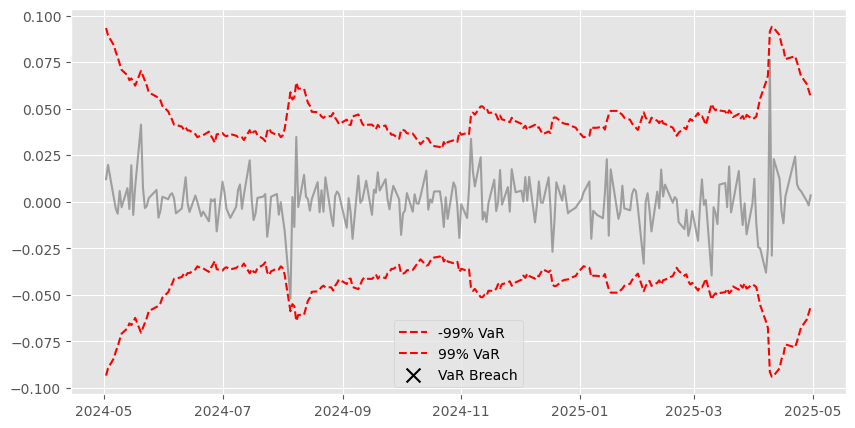

In [163]:
plt.plot(res_df['Ret'], color='grey', alpha=0.7)
plt.plot(-res_df['VaR'], label=f'-{int((1-0.01)*100)}% VaR', color='red', linestyle='--')
plt.plot(res_df['VaR'], label=f'{int((1-0.01)*100)}% VaR', color='red', linestyle='--')
plt.scatter(VaR_breached.index, VaR_breached.Ret, color='black', label='VaR Breach', marker='x',s = 100)
plt.legend()
plt.show()

In [63]:
from statsmodels.stats.proportion import proportions_ztest

1. **Zero Exceptions:**  
   - Out of 248 out‐of‐sample days, there were **no breaches** of the 99% VaR threshold. Every realized return was “safer” (less negative) than the predicted lower bound.

2. **Empirical vs. Theoretical Rate:**  
   - The target (theoretical) exception rate is 1% (i.e. roughly 2.5 breaches in 248 days), but we observed **0%**. In other words, the model never allowed a single daily log‐return to fall below the 99% lower quantile.

3. **Kupiec POF Test p‐Value = 1.0000:**  
   - The null hypothesis is that the true breach probability equals 1%. A p‐value of 1.000 means we completely fail to reject that null—in fact, we see far fewer breaches than expected under a correct 1% model.  


In [185]:
exceptions = (res_df['Ret'] < res_df['VaR']).astype(int)
n_exceptions = exceptions.sum()
n_tests = exceptions.count()
empirical_rate = n_exceptions / n_tests
theoretical_rate = 0.001

In [188]:
from scipy.stats import chi2

def christoffersen_independence_test(violations):

    Vi = violations
    N00 = np.sum((Vi[:-1] == 0) & (Vi[1:] == 0))
    N01 = np.sum((Vi[:-1] == 0) & (Vi[1:] == 1))
    N10 = np.sum((Vi[:-1] == 1) & (Vi[1:] == 0))
    N11 = np.sum((Vi[:-1] == 1) & (Vi[1:] == 1))

    pi0 = N01 / (N00 + N01) if (N00 + N01) > 0 else 0
    pi1 = N11 / (N10 + N11) if (N10 + N11) > 0 else 0

    L0 = ((1 - (N01+N11)/(N00+N01+N10+N11))**(N00+N10) *
          ((N01+N11)/(N00+N01+N10+N11))**(N01+N11))
    L1 = ((1 - pi0)**N00 * pi0**N01 * (1 - pi1)**N10 * pi1**N11)

    LR_ind = -2 * (np.log(L0) - np.log(L1))
    p_value = 1 - chi2.cdf(LR_ind, df=1)
    return LR_ind, p_value


def christoffersen_conditional_coverage_test(violations, alpha):
    n = len(violations)
    x = np.sum(violations)
    L_uc = (alpha**x) * ((1 - alpha)**(n - x))
    L_bin = ((x/n)**x) * ((1 - x/n)**(n - x))
    LR_uc = -2 * (np.log(L_uc) - np.log(L_bin))

    LR_ind, _ = christoffersen_independence_test(violations)

    LR_cc = LR_uc + LR_ind
    p_value = 1 - chi2.cdf(LR_cc, df=2)
    return LR_cc, p_value

In [187]:
kp_stat, kp_p = proportions_ztest(
    count=n_exceptions,
    nobs=n_tests,
    value=theoretical_rate,
    alternative='larger'
)

ci_stat, ci_p = christoffersen_independence_test(exceptions)
ccc_stat, ccc_p = christoffersen_conditional_coverage_test(exceptions, theoretical_rate)

print(f"Total Observations: {n_tests}")
print(f"Exceptions: {n_exceptions} (Empirical Rate: {empirical_rate:.4f})")
print(f"Kupiec POF Test: Stat={kp_stat:.4f}, p-value={kp_p:.4f}\n")
print(f"Christoffersen Independence Test: Stat={ci_stat:.4f}, p-value={ci_p:.4f}")
print(f"Christoffersen Conditional Coverage Test: Stat={ccc_stat:.4f}, p-value={ccc_p:.4f}")

Total Observations: 248
Exceptions: 0 (Empirical Rate: 0.0000)
Kupiec POF Test: Stat=-inf, p-value=1.0000

Christoffersen Independence Test: Stat=-0.0000, p-value=1.0000
Christoffersen Conditional Coverage Test: Stat=0.4962, p-value=0.7803


1. **Kupiec POF Test (Proportion‐of‐Failures)**  
   - We tested whether the observed exception rate matches the target 1% level.  
   - If the _p‐value_ is **< 0.05**, we reject the null and conclude the model underestimates tail risk (too many breaches).  
   - If the _p‐value_ is **> 0.05**, we fail to reject the null and deem the frequency of breaches acceptable.

2. **Christoffersen Independence Test**  
   - We tested whether breaches occur independently (no clustering).  
   - A _p‐value_ **> 0.05** indicates no evidence of serial correlation among the VaR exceptions—breaches are randomly distributed over time.  
   - A _p‐value_ **< 0.05** signals clustering, which means the model does not adjust quickly enough after a breach.

3. **Christoffersen Conditional Coverage Test**  
   - This joint test combines the POF and Independence tests to verify both correct frequency and randomness of breaches.  
   - A _p‐value_ **> 0.05** means the model passes both coverage and independence requirements.  
   - A _p‐value_ **< 0.05** indicates failure in at least one dimension (either wrong breach rate or clustering).
